### Daytum Course: Data Analytics, Geostatistics and Machine Learning Deep Dive

### Spatial Stochastic Simulation Demonstration and Exercise

#### Goal

Reservoir property simulation.

#### Description

Here's a simple, documented workflow, demonstration of reservoir property spatial simulation for subsurface modeling workflows. This should help you get started with building subsurface models that integrate machine learning to integrate data sources. 

Here's a simple workflow for spatial simulation with SGSIM. This method is ciritical for:

* Building spatial models that honor the univariate and spatial distribution of the property of interest 

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting


If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Load the Required Libraries

The following code loads the required libraries.

In [2]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extra a limited sample so that the spatial samples are not too dense.  This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [3]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load the data from Dr. Pyrcz's github repository
df.describe()                                             # summary statistics 
df = df.sample(50)                                        # extract 50 samples
df = df.reset_index()                                     # reset the record index 
df['logPerm'] = np.log(df['Perm'].values)
df.head()

,index,X,Y,Facies,Porosity,Perm,logPerm
0,206,400,99,1,0.123665,4.412897,1.484531
1,271,20,849,1,0.089798,0.946485,-0.055000
2,233,430,889,1,0.200420,669.921340,6.507160
3,169,790,739,0,0.079962,0.111985,-2.189389
4,76,840,949,1,0.141307,18.635578,2.925073


#### Sequential Gaussian Simulation

Let's jump right to building a variety of models with simulation and visualizing the results.  We will start with a test, comparision of simulation with simple and ordinary kriging.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search


Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1895 (close to 0.0?)
                                   variance = 0.841 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2328 (close to 0.0?)
                                   variance = 0.8871 (close to gammabar(V,V)? approx. 1.0)


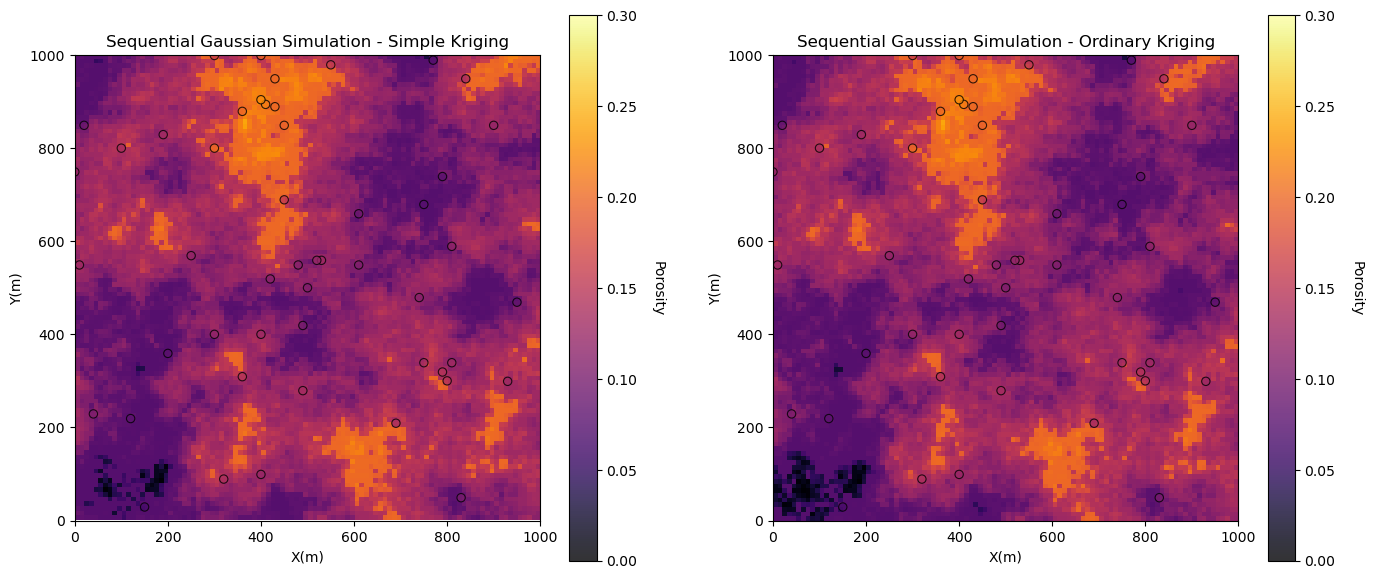

In [4]:
# Simple Kriging vs. Ordinary Kriging
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 400; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=300,hmin1=300)
tmin = -999; tmax = 999

sim_sk = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

sim_ok = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=1,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)                                          # plot the results
GSLIB.locpix_st(sim_sk[0],xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - Simple Kriging','X(m)','Y(m)','Porosity',cmap)
plt.subplot(222)
GSLIB.locpix_st(sim_ok[0],xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - Ordinary Kriging','X(m)','Y(m)','Porosity',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Exploring Geometric Anisotropy

Le'ts look at 4 realizations of porosity all with short range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0115 (close to 0.0?)
                                   variance = 1.0841 (close to gammabar(V,V)? approx. 1.0)


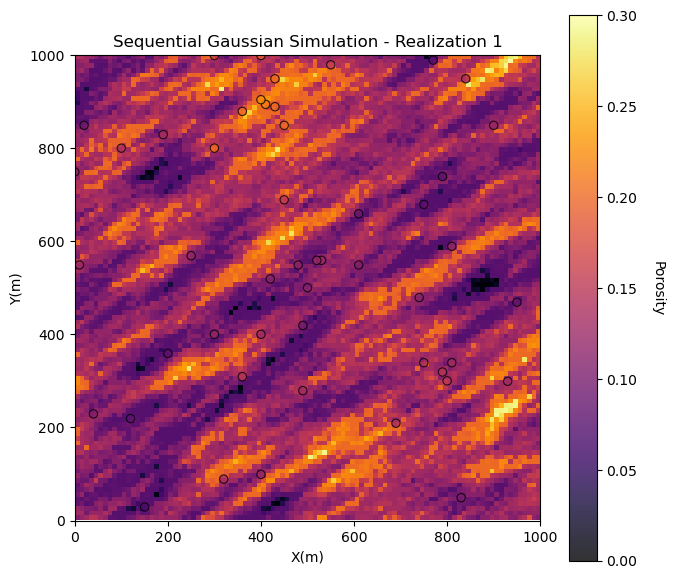

In [5]:
# Strongly Anisotropic Realization
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 200; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=200,hmin1=50)
tmin = -999; tmax = 999

sim_anis = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim_anis[0],xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Exploring Multiple Realizations

Let's look at 4 realizations of porosity all with short range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000

   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.031 (close to 0.0?)
                                   variance = 1.0052 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0166 (close to 0.0?)
                                   variance = 0.9521 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.004 (close to 0.0?)
                                   variance = 0.9978 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.014 (close to 0.0?)
                                   variance = 0.9801 (close to gammabar(V,V)? approx. 1.0)


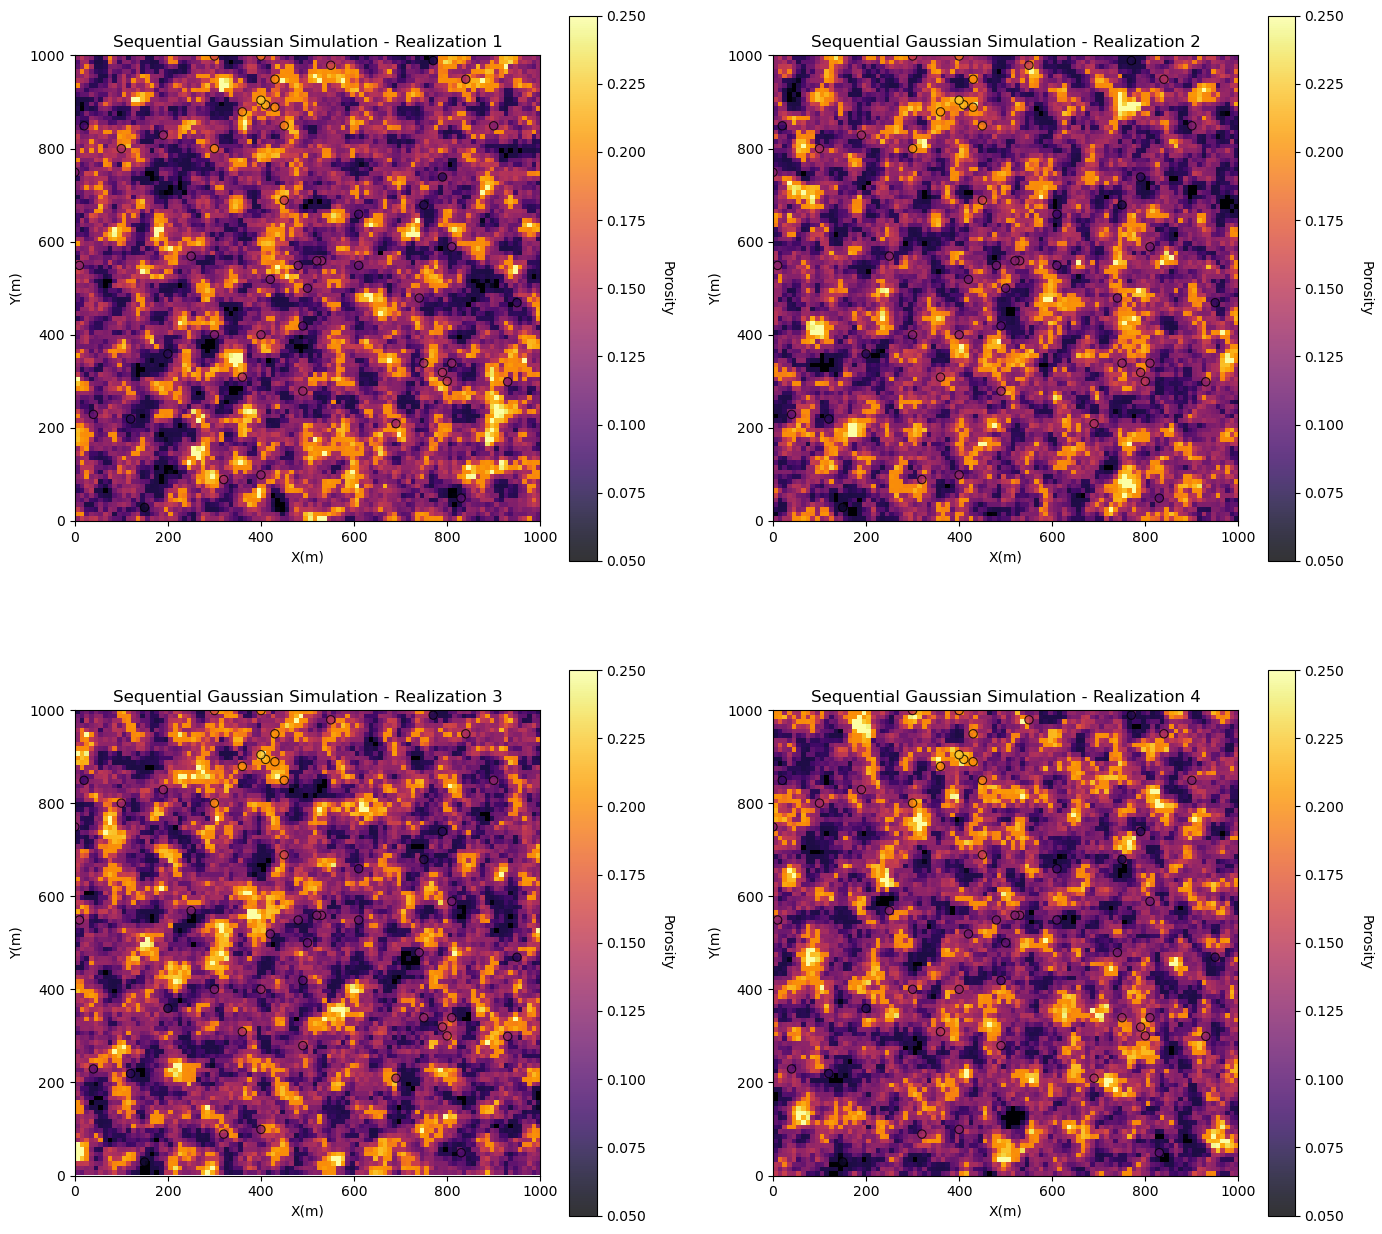

In [6]:
# Demonstration of Multiple Realizations - Short Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 50; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=50,hmin1=50)
tmin = -999; tmax = 999

sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim3 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim4 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73070,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(sim2[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locpix_st(sim3[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplot(224)
GSLIB.locpix_st(sim4[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 4','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

Let's look at 4 realizations of porosity all with long range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1967 (close to 0.0?)
                                   variance = 0.7316 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1611 (close to 0.0?)
                                   variance = 0.741 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1172 (close to 0.0?)
                                   variance = 0.61 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1762 (close to 0.0?)
                                   variance = 0.7877 (close to gammabar(V,V)? approx. 1.0)


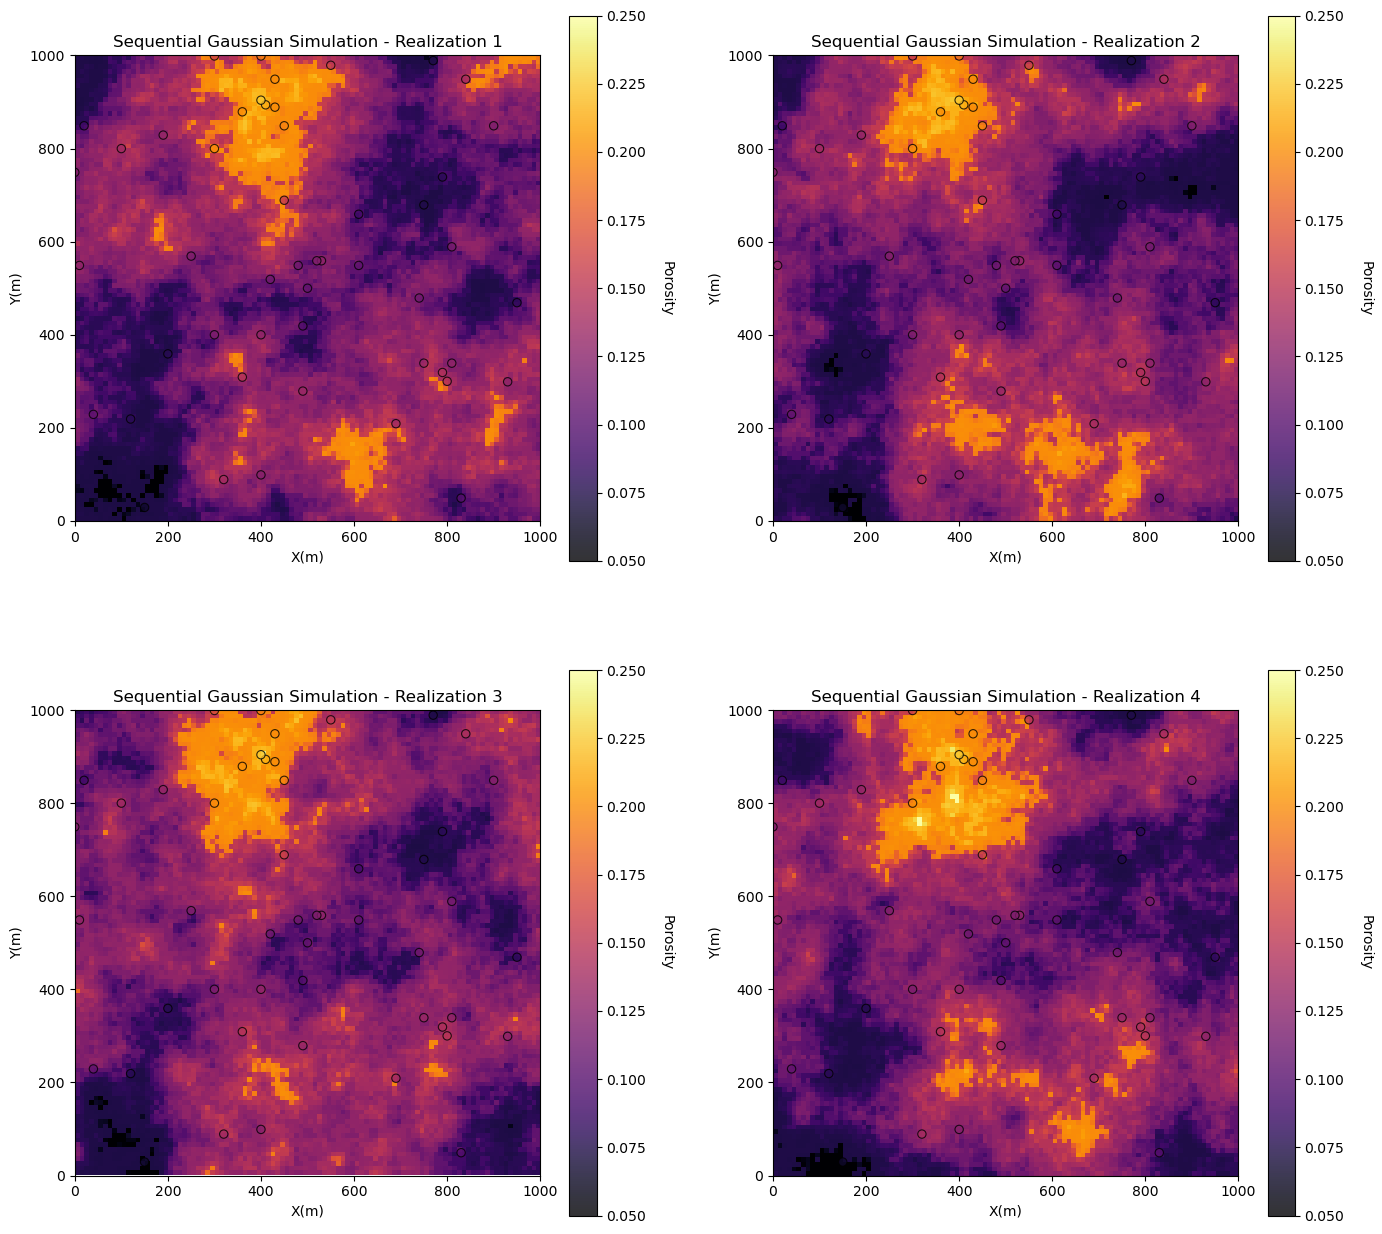

In [7]:
# Demonstration of Multiple Realizations - Long Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 100; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=500,hmin1=500)
tmin = -999; tmax = 999

sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim3 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim4 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73070,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(sim2[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locpix_st(sim3[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplot(224)
GSLIB.locpix_st(sim4[0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 4','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Sequential Gaussian Simulation - Collocated Cokriging

Now let's demonstrate collocated cokriging.  We first calculate a realization of porosity and then collocated cokriging realization of permeability constrained to the porosity realizations.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1305
                 Weighted Variance             = 0.0015
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.025 (close to 0.0?)
                                   variance = 0.9623 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 163.962
                 Weighted Variance             = 187094.31
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.1295
                 Equal Weighted Variance    = 0.0015
 Transforming Secondary Data with
 variance reduction of 1.0
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0


   currently on node 1000


   currently on node 2000


   currently on node 3000


   currently on node 4000


   currently on node 5000


   currently on node 6000


   currently on node 7000


   currently on node 8000


   currently on node 9000


Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0029 (close to 0.0?)
                                   variance = 1.0327 (close to gammabar(V,V)? approx. 1.0)


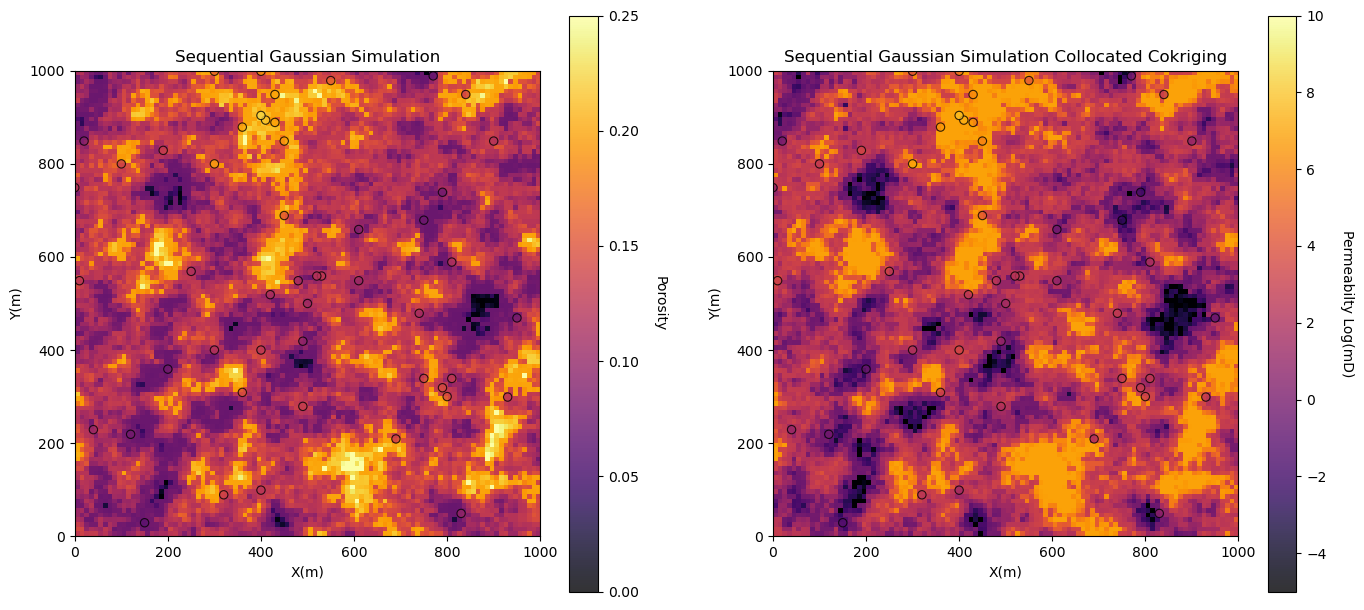

In [8]:
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 100; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=100,hmin1=100)
tmin = -99999; tmax = 99999

trend = np.zeros((ny,nx))
for iy in range(0,ny):
    for ix in range(0,nx):
        trend[iy,ix] = -1*(iy-ny/2)/(ny)*0.03+.127
#trend = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]]) 
    
sim_por = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=trend,vario=vario)

sim_perm = geostats.sgsim(df,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=1000.0,ltail=1,ltpar=0.0,utail=1,utpar=1000.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73075,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=4,colocorr=0.9,sec_map=sim_por[0],vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(121)
GSLIB.locpix_st(sim_por[0],xmin,xmax,ymin,ymax,xsiz,0.0,0.250,df,'X','Y','Porosity','Sequential Gaussian Simulation','X(m)','Y(m)','Porosity',cmap)
sim_log_perm = np.log(sim_perm.clip(0.0001,1200))
plt.subplot(122)
GSLIB.locpix_st(sim_log_perm[0],xmin,xmax,ymin,ymax,xsiz,-5.0,10,df,'X','Y','logPerm','Sequential Gaussian Simulation Collocated Cokriging','X(m)','Y(m)','Permeabilty Log(mD)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

<i>&copy; Copyright daytum 2025. All Rights Reserved</i>